In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt

 
plt.style.use(['science','notebook'])
plt.style.reload_library()

In [3]:
from june import World 
from june.geography import Geography
from june.demography import Demography
from june.interaction import Interaction
from june.infection import Infection, HealthIndexGenerator, InfectionSelector
from june.infection.transmission import TransmissionConstant
from june.groups import Hospitals, Schools, Companies, Households, CareHomes, Cemeteries, Universities
from june.groups.leisure import generate_leisure_for_config, Cinemas, Pubs, Groceries
from june.groups.travel import *
from june.simulator import Simulator
from june.infection_seed import InfectionSeed
from june.policy import Policy, Policies
from june import paths
from june.hdf5_savers import load_geography_from_hdf5
from june.records import Record, RecordReader

from june.world import generate_world_from_geography
from june.hdf5_savers import generate_world_from_hdf5

No --data argument given - defaulting to:
/home/florpi/JUNE/data
No --configs argument given - defaulting to:
/home/florpi/JUNE/configs


2020-10-15 18:46:14,008 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


# Initialize world

To initialize a certain world, we need to add the different components we want to have in it. First we specify what super areas (msoa) we want to create. We have included these ones, because they are known to contain hospitals, schools, care homes, and companies.

After creating the geography, we create the different components the worlds need to have such as care homes, companies ...

In [4]:
CONFIG_PATH = paths.configs_path / "config_example.yaml"

In [5]:
%%time 

geography = Geography.from_file(
{
    "super_area": ["E02001731", "E02002566","E02004935","E02000134", "E02004987"]
}
)

geography.hospitals = Hospitals.for_geography(geography)
geography.schools = Schools.for_geography(geography)
geography.companies = Companies.for_geography(geography)
geography.care_homes = CareHomes.for_geography(geography)
geography.universities = Universities.for_super_areas(geography.super_areas)
world = generate_world_from_geography(geography, include_households=True)


2020-10-15 18:46:14,916 - june.geography.geography - INFO - There are 151 areas and 5 super_areas and 3 in the world.
2020-10-15 18:46:14,926 - june.groups.hospital - INFO - There are 1 hospitals in this geography.
2020-10-15 18:46:15,023 - june.groups.school - INFO - There are 16 schools in this geography.
2020-10-15 18:46:15,068 - june.groups.school - INFO - No school for the age 0 in this world.
2020-10-15 18:46:15,078 - june.groups.school - INFO - No school for the age 1 in this world.
2020-10-15 18:46:15,738 - june.groups.care_home - INFO - There are 14 care_homes in this geography.
2020-10-15 18:46:15,847 - june.groups.university - INFO - There are 37 universities in this world.
2020-10-15 18:46:24,989 - june.world - INFO - Populating areas
2020-10-15 18:46:25,841 - june.world - INFO - Areas populated. This world's population is: 44314
2020-10-15 18:46:29,609 - june.distributors.worker_distributor - INFO - Distributing workers to super areas...
2020-10-15 18:46:31,937 - june.dist

## Commute, travel and leisure

In [6]:
%%time

world.pubs = Pubs.for_geography(geography)
world.cinemas = Cinemas.for_geography(geography)
world.groceries = Groceries.for_geography(geography)
leisure = generate_leisure_for_config(world, config_filename=CONFIG_PATH)
leisure.distribute_social_venues_to_areas(
    areas=world.areas, super_areas=world.super_areas
)


2020-10-15 18:46:47,585 - june.groups.leisure.social_venue - INFO - Domain 0 has 800 pubs(s)
2020-10-15 18:46:47,610 - june.groups.leisure.social_venue - INFO - Domain 0 has 8 cinemas(s)
2020-10-15 18:46:47,708 - june.groups.leisure.social_venue - INFO - Domain 0 has 69 groceries(s)
2020-10-15 18:46:47,779 - june.groups.leisure.leisure - INFO - Linking households for visits
2020-10-15 18:46:48,596 - june.groups.leisure.leisure - INFO - Done
2020-10-15 18:46:48,597 - june.groups.leisure.leisure - INFO - Linking households with care homes for visits
2020-10-15 18:46:48,788 - june.groups.leisure.leisure - INFO - Done
2020-10-15 18:46:48,789 - june.groups.leisure.leisure - INFO - Distributing social venues to areas
2020-10-15 18:46:48,789 - june.groups.leisure.leisure - INFO - Distributed in 0 of 151 areas.
2020-10-15 18:46:48,950 - june.groups.leisure.leisure - INFO - Distributed in 151 of 151 areas.
CPU times: user 1.8 s, sys: 18.4 ms, total: 1.81 s
Wall time: 1.91 s


In [7]:
# initialise commuting travel
travel = Travel()
travel.initialise_commute(world)

2020-10-15 18:46:49,031 - june.groups.travel.travel - INFO - Initialising commute...
2020-10-15 18:46:49,040 - june.groups.travel.travel - INFO - Creating cities...
2020-10-15 18:46:49,080 - june.groups.travel.travel - INFO - This world has 4 cities, with names
['London', 'Newcastle upon Tyne', 'Darlington', 'St Albans']
2020-10-15 18:46:49,082 - june.groups.travel.travel - INFO - Creating stations...
2020-10-15 18:46:49,086 - june.groups.travel.travel - INFO - City London has 8 stations.
2020-10-15 18:46:49,089 - june.groups.travel.travel - INFO - City Newcastle upon Tyne has 4 stations.
2020-10-15 18:46:49,090 - june.groups.travel.travel - INFO - This world has 12 stations.
2020-10-15 18:46:49,091 - june.groups.travel.travel - INFO - Recording closest stations to super areas
2020-10-15 18:46:49,094 - june.groups.travel.travel - INFO - Determining people mode of transport
2020-10-15 18:47:00,864 - june.groups.travel.travel - INFO - Mode of transport allocated in 0 of 151 areas.
2020-1

We are also going to need some cemeteries...


In [8]:
world.cemeteries = Cemeteries()

In [9]:
len(world.people)

44314

### If it took a long time to run the previous commands, it might be a good idea to save the world to reuse it later.

In [10]:
world.to_hdf5("world.hdf5")

2020-10-15 18:47:01,562 - june.hdf5_savers.world_saver - INFO - saving world to HDF5
2020-10-15 18:47:01,627 - june.hdf5_savers.world_saver - INFO - saving population...
2020-10-15 18:47:03,096 - june.hdf5_savers.world_saver - INFO - saving hospitals...
2020-10-15 18:47:03,103 - june.hdf5_savers.world_saver - INFO - saving schools...
2020-10-15 18:47:03,112 - june.hdf5_savers.world_saver - INFO - saving companies...
2020-10-15 18:47:03,138 - june.hdf5_savers.world_saver - INFO - saving households...
2020-10-15 18:47:03,600 - june.hdf5_savers.world_saver - INFO - saving care homes...
2020-10-15 18:47:03,605 - june.hdf5_savers.world_saver - INFO - saving cities...
2020-10-15 18:47:03,613 - june.hdf5_savers.world_saver - INFO - saving stations...
2020-10-15 18:47:03,618 - june.hdf5_savers.world_saver - INFO - saving universities...
2020-10-15 18:47:03,621 - june.hdf5_savers.world_saver - INFO - saving social venues...


If we would like to load the world we saved, we just do

In [11]:
world = generate_world_from_hdf5("world.hdf5")

2020-10-15 18:47:03,708 - june.hdf5_savers.world_saver - INFO - loading world from HDF5
2020-10-15 18:47:03,738 - june.hdf5_savers.world_saver - INFO - loading hospitals...
2020-10-15 18:47:03,745 - june.hdf5_savers.world_saver - INFO - loading schools...
2020-10-15 18:47:03,757 - june.hdf5_savers.company_saver - INFO - loading companies...
2020-10-15 18:47:03,759 - june.hdf5_savers.company_saver - INFO - Companies chunk 0 of 1
2020-10-15 18:47:03,898 - june.hdf5_savers.world_saver - INFO - loading care homes...
2020-10-15 18:47:03,903 - june.hdf5_savers.world_saver - INFO - loading universities...
2020-10-15 18:47:03,921 - june.hdf5_savers.world_saver - INFO - loading cities...
2020-10-15 18:47:03,930 - june.hdf5_savers.world_saver - INFO - loading stations...
2020-10-15 18:47:03,938 - june.hdf5_savers.household_saver - INFO - loading households...
2020-10-15 18:47:03,942 - june.hdf5_savers.household_saver - INFO - Households chunk 0 of 1
2020-10-15 18:47:04,265 - june.hdf5_savers.pop

In [12]:
# and regenerate leisure in case we load it externally
leisure = generate_leisure_for_config(world, CONFIG_PATH)
# create travel as well
travel = Travel()

you have now a beautiful pre-pandemic world. 

# Adding the infection

The module in charge of infecting people is called the ``InfectionSelector``, which gives people a transmission time profile and a symptoms trajectory based on their age and sex (through the health index generator)

In [13]:
health_index_generator = HealthIndexGenerator.from_file(asymptomatic_ratio=0.2)
selector = InfectionSelector.from_file(
        health_index_generator=health_index_generator,
        transmission_config_path=paths.configs_path / 'defaults/transmission/XNExp.yaml'
)

# Adding the interaction

In [14]:
interaction = Interaction.from_file(population=world.people)

Beta are the intensities of the interaction taking place at the different groups

In [15]:
interaction.beta

{'box': 1,
 'pub': 0.42941,
 'grocery': 0.04137,
 'cinema': 0.157461,
 'city_transport': 0.107969,
 'inter_city_transport': 0.383,
 'hospital': 0.1168,
 'care_home': 0.28,
 'company': 0.371,
 'school': 0.07,
 'household': 0.208,
 'university': 0.306}

moreover this interaction module uses contact matrices, that are different for different groups. These contact matrices shouldnt be modified for now. However they are a combination of conversational contact matrices, and physical contact matrices (see the BBC pandemic paper, from where these matrices are extracted https://www.medrxiv.org/content/10.1101/2020.02.16.20023754v2)

There is a parameter, ``alpha`` ($\alpha$), that combines these two matrices in the following way,


$\beta M \left(1 + (\alpha -1) \right) P$

where $\beta$ is the intensity of the interaction, and $P$ the physical contact matrix. A larger $\alpha$ produces more physical contacts. It is an overall number, non dependent of the particular group.


In [16]:
interaction.alpha_physical

2.0

# Seed the disease

There are two options implemented in the seed at the moment, either you specify the number of cases and these are then homogeneously distributed by population to the different areas, or you use UK data on cases per region. For now use the first case.

In [17]:
infection_seed = InfectionSeed(
    world, selector,
)

In [18]:
n_cases = 50
infection_seed.unleash_virus(
    population=world.people,
    n_cases=n_cases) # play around with the initial number of cases

# Set policies

In [19]:
policies = Policies.from_file()

We can have a look at one of the policies

In [20]:
print(policies.individual_policies[1].__dict__)

{'spec': 'quarantine', 'start_time': datetime.datetime(2020, 3, 16, 0, 0), 'end_time': datetime.datetime(2020, 3, 24, 0, 0), 'policy_type': 'individual', 'policy_subtype': 'stay_home', 'n_days': 7, 'n_days_household': 14, 'compliance': 0.5, 'household_compliance': 0.2}


# Run the simulation

The simulator is the main module in charge of running the simulation. It coordinates the ``ActivityManager`` which is responsible of allocating people to the right groups given the current timestep, it updates the health status of the population, and it runs the interaction over the different groups. All of these modules can be modified by policies at any given time.

Since the timer configuration is a bit cumbersome, it is read from the config file at ``configs/config_example.yaml``

In [21]:
record = Record(    
    record_path = 'results',    
    record_static_data=True,
) 

In [22]:
record.static_data(world=world)

In [23]:
simulator = Simulator.from_file(
    world=world,
    infection_selector=selector,
    interaction=interaction, 
    config_filename = CONFIG_PATH,
    leisure = leisure,
    travel = travel,
    record=record,
    policies = policies
)

In [24]:
%%time
simulator.run()

2020-10-15 18:47:08,756 - june.simulator - INFO - Starting simulation for 60 days at day 2020-03-01 00:00:00, to run for 60 days
2020-10-15 18:47:09,019 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:47:09,456 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.868998075835407e-06,4.0531158447265625e-06 - 2020-03-01 00:00:00
2020-10-15 18:47:09,464 - june.simulator - INFO - Info for rank 0, Date = 2020-03-01 00:00:00, number of deaths =  0, number of infected = 50
2020-10-15 18:47:09,752 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00806907498918008,0.008066892623901367 - 2020-03-01 00:00:00
2020-10-15 18:47:10,011 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 0.9915009729884332, 0.9915015697479248 - 2020-03-01 00:00:00

2020-10-15 18:47:10,016 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:47:10,519 - june.activity.activity_manager - INFO - CMS

2020-10-15 18:47:17,881 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00013840600149706006,0.0001380443572998047 - 2020-03-03 09:00:00
2020-10-15 18:47:18,013 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 0.5912660150061129, 0.5912671089172363 - 2020-03-03 09:00:00

2020-10-15 18:47:18,014 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:47:18,504 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.682005965150893e-06,4.0531158447265625e-06 - 2020-03-03 10:00:00
2020-10-15 18:47:18,512 - june.simulator - INFO - Info for rank 0, Date = 2020-03-03 10:00:00, number of deaths =  0, number of infected = 138
2020-10-15 18:47:18,793 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00021592499979306012,0.00021529197692871094 - 2020-03-03 10:00:00
2020-10-15 18:47:18,920 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 0.9041555709991371, 0.9041569232940674 - 2020-03-03 10:00:

2020-10-15 18:47:28,957 - june.simulator - INFO - Info for rank 0, Date = 2020-03-05 13:00:00, number of deaths =  0, number of infected = 420
2020-10-15 18:47:29,219 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.0002381329977652058,0.00023794174194335938 - 2020-03-05 13:00:00
2020-10-15 18:47:29,362 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 0.659422873010044, 0.6594233512878418 - 2020-03-05 13:00:00

2020-10-15 18:47:29,363 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:47:29,592 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 6.842004950158298e-06,6.198883056640625e-06 - 2020-03-06 00:00:00
2020-10-15 18:47:29,601 - june.simulator - INFO - Info for rank 0, Date = 2020-03-06 00:00:00, number of deaths =  0, number of infected = 449
2020-10-15 18:47:29,921 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.000214478000998497,0.0002143383026123047 - 2020-03-06 00:00:00

2020-10-15 18:47:40,455 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.889006959274411e-06,3.814697265625e-06 - 2020-03-08 08:00:00
2020-10-15 18:47:40,464 - june.simulator - INFO - Info for rank 0, Date = 2020-03-08 08:00:00, number of deaths =  0, number of infected = 991
2020-10-15 18:47:40,787 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00015095500566530973,0.00015044212341308594 - 2020-03-08 08:00:00
2020-10-15 18:47:40,959 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 0.9745248420076678, 0.9745256900787354 - 2020-03-08 08:00:00

2020-10-15 18:47:40,962 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:47:41,178 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 7.093010935932398e-06,5.9604644775390625e-06 - 2020-03-08 12:00:00
2020-10-15 18:47:41,191 - june.simulator - INFO - Info for rank 0, Date = 2020-03-08 12:00:00, number of deaths =  0, number of infe

2020-10-15 18:47:50,720 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 0.7103536260110559, 0.7103538513183594 - 2020-03-10 13:00:00

2020-10-15 18:47:50,721 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:47:50,903 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.699999746866524e-06,5.0067901611328125e-06 - 2020-03-11 00:00:00
2020-10-15 18:47:50,912 - june.simulator - INFO - Info for rank 0, Date = 2020-03-11 00:00:00, number of deaths =  0, number of infected = 2867
2020-10-15 18:47:51,169 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.0001612310006748885,0.00016117095947265625 - 2020-03-11 00:00:00
2020-10-15 18:47:51,297 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 0.5749624989985023, 0.574970006942749 - 2020-03-11 00:00:00

2020-10-15 18:47:51,298 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:47:51,502 - june.activity.activity_man

2020-10-15 18:48:00,056 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00017373300215695053,0.0001735687255859375 - 2020-03-13 01:00:00
2020-10-15 18:48:00,225 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.2091749779938255, 1.2091760635375977 - 2020-03-13 01:00:00

2020-10-15 18:48:00,226 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:48:00,420 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 6.685993866994977e-06,5.9604644775390625e-06 - 2020-03-13 09:00:00
2020-10-15 18:48:00,428 - june.simulator - INFO - Info for rank 0, Date = 2020-03-13 09:00:00, number of deaths =  0, number of infected = 7536
2020-10-15 18:48:00,740 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00019310500647407025,0.0001926422119140625 - 2020-03-13 09:00:00
2020-10-15 18:48:00,915 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 0.6886486059956951, 0.6886491775512695 - 2020-03-13 09:00:

2020-10-15 18:48:10,893 - june.simulator - INFO - Info for rank 0, Date = 2020-03-16 00:00:00, number of deaths =  0, number of infected = 11203
2020-10-15 18:48:11,176 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00018006199388764799,0.00017952919006347656 - 2020-03-16 00:00:00
2020-10-15 18:48:11,375 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 0.9302798110002186, 0.9302806854248047 - 2020-03-16 00:00:00

2020-10-15 18:48:11,375 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:48:11,862 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.5779888750985265e-06,3.814697265625e-06 - 2020-03-16 01:00:00
2020-10-15 18:48:11,871 - june.simulator - INFO - Info for rank 0, Date = 2020-03-16 01:00:00, number of deaths =  0, number of infected = 11315
2020-10-15 18:48:12,737 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.0001302720047533512,0.00012993812561035156 - 2020-03-16 01

2020-10-15 18:48:24,686 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:48:25,115 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.635003278963268e-06,4.0531158447265625e-06 - 2020-03-18 09:00:00
2020-10-15 18:48:25,125 - june.simulator - INFO - Info for rank 0, Date = 2020-03-18 09:00:00, number of deaths =  1, number of infected = 18744
2020-10-15 18:48:25,598 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00015075500414241105,0.0001506805419921875 - 2020-03-18 09:00:00
2020-10-15 18:48:25,860 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.1699422579986276, 1.1699433326721191 - 2020-03-18 09:00:00

2020-10-15 18:48:25,861 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:48:26,525 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 1.5034005627967417e-05,1.0967254638671875e-05 - 2020-03-18 10:00:00
2020-10-15 18:48:26,539 -

2020-10-15 18:48:39,887 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00015199001063592732,0.00015211105346679688 - 2020-03-20 10:00:00
IN ICU
IN ICU
2020-10-15 18:48:40,188 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.596265512998798, 1.596266269683838 - 2020-03-20 10:00:00

2020-10-15 18:48:40,188 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:48:40,680 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.861998604610562e-06,4.291534423828125e-06 - 2020-03-20 13:00:00
2020-10-15 18:48:40,696 - june.simulator - INFO - Info for rank 0, Date = 2020-03-20 13:00:00, number of deaths =  1, number of infected = 24317
2020-10-15 18:48:41,183 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.0001711149961920455,0.00017023086547851562 - 2020-03-20 13:00:00
IN ICU
IN ICU
2020-10-15 18:48:41,481 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.2919832640036475, 1.291984081

IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
2020-10-15 18:48:56,163 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.7011616279924056, 1.701162338256836 - 2020-03-23 01:00:00

2020-10-15 18:48:56,164 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:48:56,779 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.382003680802882e-06,3.814697265625e-06 - 2020-03-23 09:00:00
2020-10-15 18:48:56,788 - june.simulator - INFO - Info for rank 0, Date = 2020-03-23 09:00:00, number of deaths =  7, number of infected = 28285
2020-10-15 18:48:57,319 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00015772201004438102,0.00015687942504882812 - 2020-03-23 09:00:00
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
2020-10-15 18:48:57,653 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.4876346210076008, 1.487635612487793 - 2020-03-23 09:00:00

2020-10-15 18:48:57,654 - june

2020-10-15 18:49:09,429 - june.simulator - INFO - Info for rank 0, Date = 2020-03-25 09:00:00, number of deaths =  17, number of infected = 30266
2020-10-15 18:49:09,751 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00021491499501280487,0.00021409988403320312 - 2020-03-25 09:00:00
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
2020-10-15 18:49:10,078 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.1242317440046463, 1.1242327690124512 - 2020-03-25 09:00:00

2020-10-15 18:49:10,079 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:49:10,611 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.9770023906603456e-06,4.0531158447265625e-06 - 2020-03-25 10:00:00
2020-10-15 18:49:10,622 - june.simulator - INFO - Info for rank 0, Date = 2020-03-25 10:00:00, number of deaths =  17, number of infected = 30305
2020-10-15 18:49:10,935 - june.simulator - INFO - CMS: Infection COMS-v2 

2020-10-15 18:49:22,978 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:49:23,720 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 6.440997822210193e-06,5.245208740234375e-06 - 2020-03-27 10:00:00
2020-10-15 18:49:23,735 - june.simulator - INFO - Info for rank 0, Date = 2020-03-27 10:00:00, number of deaths =  28, number of infected = 31421
2020-10-15 18:49:24,245 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.0002064019936369732,0.00020599365234375 - 2020-03-27 10:00:00
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
2020-10-15 18:49:24,858 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.879233405998093, 1.8792340755462646 - 2020-03-27 10:00:00

2020-10-15 18:49:24,862 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:49:25,661 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.44999784324

2020-10-15 18:49:47,173 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00018380700203124434,0.00018334388732910156 - 2020-03-30 00:00:00
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
2020-10-15 18:49:47,718 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.7033270689862547, 1.703326940536499 - 2020-03-30 00:00:00

2020-10-15 18:49:47,720 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:49:48,640 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.6910066632553935e-06,5.0067901611328125e-06 - 2020-03-30 01:00:00
2020-10-15 18:49:48,656 - june.simulator - INFO - Info for rank 0, Date = 2020-03-30 01:00:00, number of deaths =  54, number of infected = 31440
2020-10-15 18:49:49,294 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00018929901125375181,0.0001888275146484375 - 2020-03-30 01:00:00
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
I

IN ICU
IN ICU
IN ICU
IN ICU
2020-10-15 18:50:03,950 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.283887350000441, 1.2838878631591797 - 2020-04-01 00:00:00

2020-10-15 18:50:03,959 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:50:04,560 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.9009977374225855e-06,4.0531158447265625e-06 - 2020-04-01 01:00:00
2020-10-15 18:50:04,573 - june.simulator - INFO - Info for rank 0, Date = 2020-04-01 01:00:00, number of deaths =  70, number of infected = 30899
2020-10-15 18:50:04,950 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00016868200327735394,0.00016832351684570312 - 2020-04-01 01:00:00
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
2020-10-15 18:50:05,389 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.4279721690109, 1.4279699325561523 - 2020-

2020-10-15 18:50:18,714 - june.simulator - INFO - Info for rank 0, Date = 2020-04-03 00:00:00, number of deaths =  79, number of infected = 29534
2020-10-15 18:50:19,035 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00013023200153838843,0.00012969970703125 - 2020-04-03 00:00:00
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
2020-10-15 18:50:19,473 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.3896680789912352, 1.3896684646606445 - 2020-04-03 00:00:00

2020-10-15 18:50:19,474 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:50:20,146 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 7.405993528664112e-06,6.198883056640625e-06 - 2020-04-03 01:00:00
2020-10-15 18:50:20,159 - june.simulator - INFO - Info for rank 0, Date = 2020-04-03 01:00:00, number of 

2020-10-15 18:50:34,567 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00023099900863599032,0.0002307891845703125 - 2020-04-05 00:00:00
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
2020-10-15 18:50:35,093 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.7606227760115871, 1.7606236934661865 - 2020-04-05 00:00:00

2020-10-15 18:50:35,094 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:50:35,979 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 6.333997589536011e-06,5.7220458984375e-06 - 2020-04-05 04:00:00
2020-10-15 18:50:36,002 - june.simulator - INFO - Info for rank 0, Date = 2020-04-05 04:00:00, number of deaths =  89, number of infected = 26906
2020-10-15 18:50:36,399 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00024396499793

IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
2020-10-15 18:50:48,508 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.1340862409997499, 1.1340866088867188 - 2020-04-07 00:00:00

2020-10-15 18:50:48,510 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:50:49,109 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 7.698996341787279e-06,6.9141387939453125e-06 - 2020-04-07 01:00:00
2020-10-15 18:50:49,124 - june.simulator - INFO - Info for rank 0, Date = 2020-04-07 01:00:00, number of deaths =  107, number of infected = 23873
2020-10-15 18:50:49,397 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00014214600378181785,0.00014209747314453125 - 2020-04-07 01:00:00
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN

2020-10-15 18:50:58,855 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.0842645299999276, 1.0842652320861816 - 2020-04-08 13:00:00

2020-10-15 18:50:58,856 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:50:59,362 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.560992238111794e-06,3.5762786865234375e-06 - 2020-04-09 00:00:00
2020-10-15 18:50:59,377 - june.simulator - INFO - Info for rank 0, Date = 2020-04-09 00:00:00, number of deaths =  121, number of infected = 20108
2020-10-15 18:50:59,708 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00012829700426664203,0.0001277923583984375 - 2020-04-09 00:00:00
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
2020-10-15 18:50:59,990 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.1328678959980607, 1.1328692

2020-10-15 18:51:09,279 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.848996806889772e-06,5.245208740234375e-06 - 2020-04-10 13:00:00
2020-10-15 18:51:09,289 - june.simulator - INFO - Info for rank 0, Date = 2020-04-10 13:00:00, number of deaths =  127, number of infected = 16992
2020-10-15 18:51:09,515 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00014848398859612644,0.0001480579376220703 - 2020-04-10 13:00:00
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
2020-10-15 18:51:09,764 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.0173292429972207, 1.0173323154449463 - 2020-04-10 13:00:00

2020-10-15 18:51:09,767 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:51:10,412 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.23

2020-10-15 18:51:19,173 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.0001629960024729371,0.00016260147094726562 - 2020-04-13 00:00:00
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
2020-10-15 18:51:19,387 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.0081065749982372, 1.0081067085266113 - 2020-04-13 00:00:00

2020-10-15 18:51:19,388 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:51:20,010 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.67000063508749e-06,3.5762786865234375e-06 - 2020-04-13 01:00:00
2020-10-15 18:51:20,024 - june.simulator - INFO - Info for rank 0, Date = 2020-04-13 01:00:00, number of deaths =  134, number of infected = 12030
2020-10-15 18:51:20,261 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.0001

2020-10-15 18:51:30,227 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.1164027839986375, 1.116403579711914 - 2020-04-14 13:00:00

2020-10-15 18:51:30,228 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:51:31,018 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.5349879655987024e-06,3.814697265625e-06 - 2020-04-15 00:00:00
2020-10-15 18:51:31,027 - june.simulator - INFO - Info for rank 0, Date = 2020-04-15 00:00:00, number of deaths =  144, number of infected = 8898
2020-10-15 18:51:31,256 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00022068100224714726,0.0002205371856689453 - 2020-04-15 00:00:00
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
2020-10-15 18:51:31,460 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.2316962479962967, 1.2316968441009521 - 

2020-10-15 18:51:39,855 - june.simulator - INFO - Info for rank 0, Date = 2020-04-16 13:00:00, number of deaths =  147, number of infected = 6854
2020-10-15 18:51:40,056 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00012457800039555877,0.0001246929168701172 - 2020-04-16 13:00:00
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
2020-10-15 18:51:40,218 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 0.7941468460048782, 0.7941479682922363 - 2020-04-16 13:00:00

2020-10-15 18:51:40,220 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:51:40,718 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.981993697583675e-06,4.0531158447265625e-06 - 2020-04-17 00:00:00
2020-10-15 18:51:40,726 - june.simulator - INFO - Info for rank 0, Date = 2020-04-17 00:00:00, number of deaths =  148, number of 

2020-10-15 18:51:51,651 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.619322459999239, 1.6193242073059082 - 2020-04-18 12:00:00

2020-10-15 18:51:51,653 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:51:52,700 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 6.6689972300082445e-06,5.7220458984375e-06 - 2020-04-19 00:00:00
2020-10-15 18:51:52,712 - june.simulator - INFO - Info for rank 0, Date = 2020-04-19 00:00:00, number of deaths =  152, number of infected = 4440
2020-10-15 18:51:53,004 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00019466799858491868,0.00019478797912597656 - 2020-04-19 00:00:00
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
2020-10-15 18:51:53,292 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.6377859490021365, 1.6377882957458496 - 2020-04-19 00:00:00

2020-10-15 1

IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
2020-10-15 18:52:04,856 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.2926160939969122, 1.2926170825958252 - 2020-04-21 00:00:00

2020-10-15 18:52:04,858 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:52:05,717 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.792003892362118e-06,4.5299530029296875e-06 - 2020-04-21 01:00:00
2020-10-15 18:52:05,728 - june.simulator - INFO - Info for rank 0, Date = 2020-04-21 01:00:00, number of deaths =  154, number of infected = 3024
2020-10-15 18:52:06,046 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00017185500473715365,0.000171661376953125 - 2020-04-21 01:00:00
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
2020-10-15 1

IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
2020-10-15 18:52:18,817 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.2068692769971676, 1.2068743705749512 - 2020-04-23 00:00:00

2020-10-15 18:52:18,825 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:52:19,868 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.927009624429047e-06,4.76837158203125e-06 - 2020-04-23 01:00:00
2020-10-15 18:52:19,877 - june.simulator - INFO - Info for rank 0, Date = 2020-04-23 01:00:00, number of deaths =  158, number of infected = 2047
2020-10-15 18:52:20,139 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.0001947029959410429,0.00019431114196777344 - 2020-04-23 01:00:00
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
2020-10-15 18:52:20,328 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.499655612

2020-10-15 18:52:33,106 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:52:34,191 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.513989551924169e-06,3.5762786865234375e-06 - 2020-04-25 04:00:00
2020-10-15 18:52:34,202 - june.simulator - INFO - Info for rank 0, Date = 2020-04-25 04:00:00, number of deaths =  158, number of infected = 1407
2020-10-15 18:52:34,490 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.0005510010087164119,0.0005500316619873047 - 2020-04-25 04:00:00
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
2020-10-15 18:52:34,665 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.5582019349967595, 1.5582029819488525 - 2020-04-25 04:00:00

2020-10-15 18:52:34,666 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:52:35,729 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 6.

2020-10-15 18:52:47,858 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.0002245700015919283,0.00022459030151367188 - 2020-04-27 10:00:00
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
2020-10-15 18:52:48,006 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 1.2605481810023775, 1.2605481147766113 - 2020-04-27 10:00:00

2020-10-15 18:52:48,007 - june.simulator - INFO - ==================== timestep ====================
2020-10-15 18:52:48,660 - june.activity.activity_manager - INFO - CMS: People COMS for rank 0/1 - 6.066009518690407e-06,5.4836273193359375e-06 - 2020-04-27 13:00:00
2020-10-15 18:52:48,669 - june.simulator - INFO - Info for rank 0, Date = 2020-04-27 13:00:00, number of deaths =  163, number of infected = 898
2020-10-15 18:52:48,916 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00024643698998261243,0.0002460479736328125 - 2020-04-27 13:00:00
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
2020-10-15 18:52:

2020-10-15 18:53:00,501 - june.simulator - INFO - Info for rank 0, Date = 2020-04-29 13:00:00, number of deaths =  164, number of infected = 616
2020-10-15 18:53:00,695 - june.simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00020070299797225744,0.00020003318786621094 - 2020-04-29 13:00:00
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
IN ICU
2020-10-15 18:53:00,849 - june.simulator - INFO - CMS: Timestep for rank 0/1 - 0.9013212580030086, 0.9013216495513916 - 2020-04-29 13:00:00

CPU times: user 5min 40s, sys: 2.11 s, total: 5min 42s
Wall time: 5min 52s


While the simulation runs (and afterwards) we can launch the visualization webpage by running
```python june/visualizer.py path/to/results``` 

# Getting the results

All results are stored in a json file specified in the ``record.record_path`` folder. Summaries are found under ``summary.csv``

In [25]:
import pandas as pd

In [26]:
read = RecordReader()

## Contains summaries with regional information

In [27]:
read.regional_summary.head(3)

,region,current_infected,daily_infected,current_recovered,daily_recovered,current_hospitalised,daily_hospitalised,current_intensive_care,daily_intensive_care,current_susceptible,daily_hospital_deaths,daily_deaths
time_stamp,,,,,,,,,,,,
2020-03-01,East of England,16.75,3,0.0,0,0.0,0,0.0,0,14325.25,0,0
2020-03-02,East of England,22.00,14,0.0,0,0.0,0,0.0,0,14320.00,0,0
2020-03-03,East of England,31.60,34,0.0,0,0.0,0,0.0,0,14310.40,0,0


In [52]:
read.regional_summary['daily_intensive_care'].sum()

0

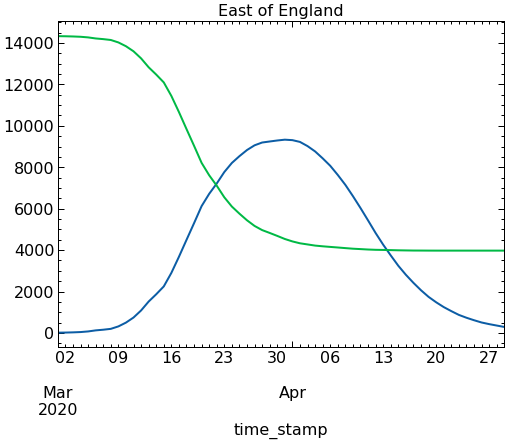

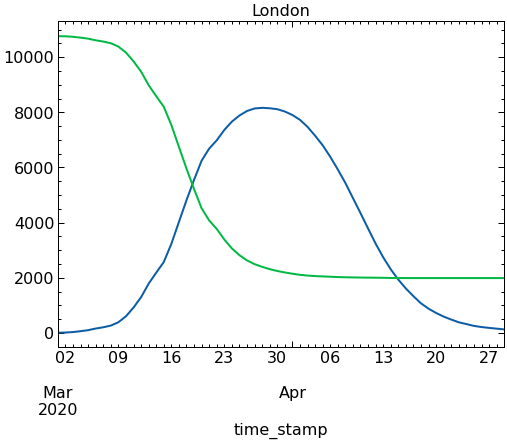

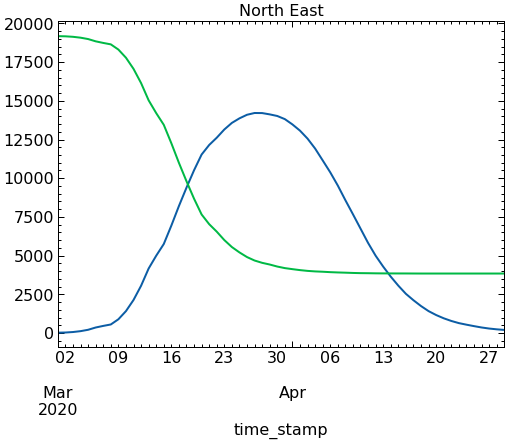

In [28]:
for region in read.regional_summary['region'].unique():
    read.regional_summary[
        read.regional_summary['region'] == region
    ]['current_infected'].plot()
    read.regional_summary[
        read.regional_summary['region'] == region
    ]['current_susceptible'].plot()
    plt.title(region)
    plt.show()

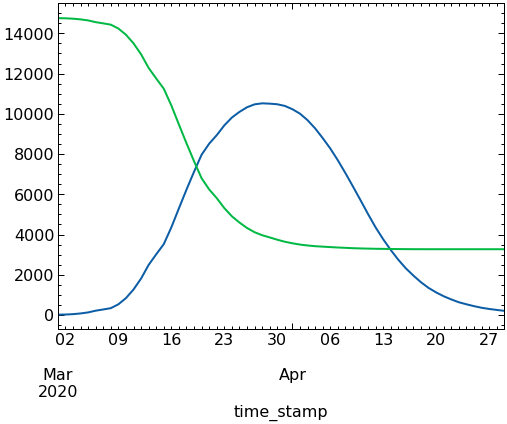

In [29]:
read.world_summary['current_infected'].plot()
read.world_summary['current_susceptible'].plot()

# Asking questions to the records

## Sero-prevalence by age

In [30]:
infections_df = read.get_table_with_extras('infections',
                                           'infected_ids')

2020-10-15 18:53:04,008 - june.records.records_reader - INFO - Loading infections table
2020-10-15 18:53:04,114 - june.records.records_reader - INFO - Loading population table
2020-10-15 18:53:04,256 - june.records.records_reader - INFO - Merging infection and population tables
2020-10-15 18:53:04,293 - june.records.records_reader - INFO - Loading geography table
2020-10-15 18:53:04,341 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [31]:
deaths_df = read.get_table_with_extras('deaths', 
                                       'dead_person_ids')

2020-10-15 18:53:04,440 - june.records.records_reader - INFO - Loading deaths table
2020-10-15 18:53:04,450 - june.records.records_reader - INFO - Loading population table
2020-10-15 18:53:04,601 - june.records.records_reader - INFO - Merging infection and population tables
2020-10-15 18:53:04,608 - june.records.records_reader - INFO - Loading geography table
2020-10-15 18:53:04,663 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [32]:
age_bins = (0,20,60,100)

In [33]:
infected_by_age = infections_df.groupby([pd.cut(infections_df['age'],
            bins=age_bins), 'timestamp']).size()

In [34]:
people_df = read.table_to_df('population')

In [35]:
n_by_age = people_df.groupby(pd.cut(people_df['age'],
            bins=age_bins)).size()

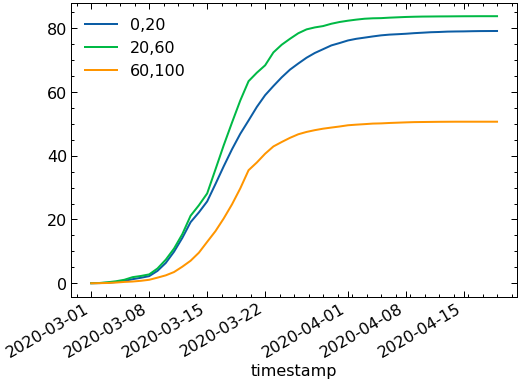

In [36]:
(100*infected_by_age/n_by_age).xs(10).cumsum().plot(label='0,20')
(100*infected_by_age/n_by_age).xs(30).cumsum().plot(label='20,60')
(100*infected_by_age/n_by_age).xs(70).cumsum().plot(label='60,100')
plt.legend()

## Care home deaths in hospital

In [37]:
care_home_deaths_hospital = deaths_df[
    (deaths_df['location_specs'] == 'hospital') 
    & (deaths_df['residence_type'] == 'care_home')
]
care_home_deaths_hospital=care_home_deaths_hospital.groupby(
    ['name_region', 'timestamp']
).size()

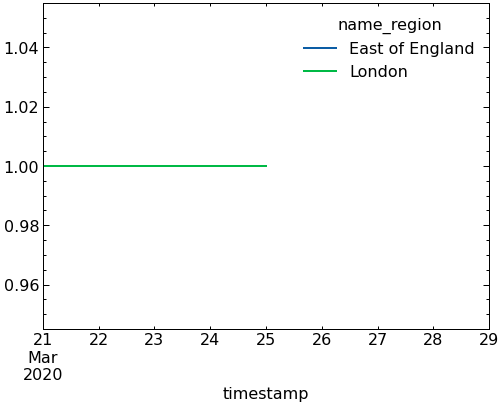

In [38]:
care_home_deaths_hospital.unstack(level=0).plot()


## Where people get infected as a function of time

In [39]:
locations_df = infections_df.groupby(['location_specs', 
                                'timestamp']).size()

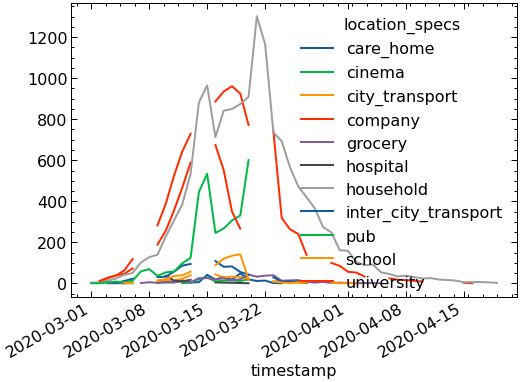

In [40]:
locations_df.unstack(level=0).plot()

Text(0.5, 0, 'location')

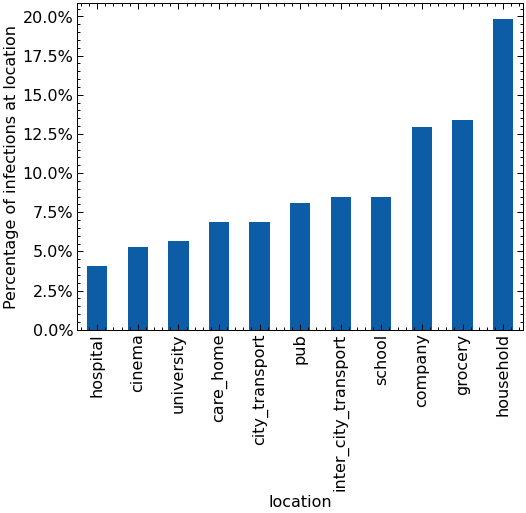

In [41]:
import matplotlib.ticker as mtick
location_counts_df = locations_df.groupby('location_specs').size()
location_counts_df = 100*location_counts_df / location_counts_df.sum()
ax = location_counts_df.sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')


## Where people of certain age get infected as a function of time

In [42]:
old_locations_df = infections_df[
    infections_df.age > 65
].groupby(['location_specs', 'timestamp']).size()

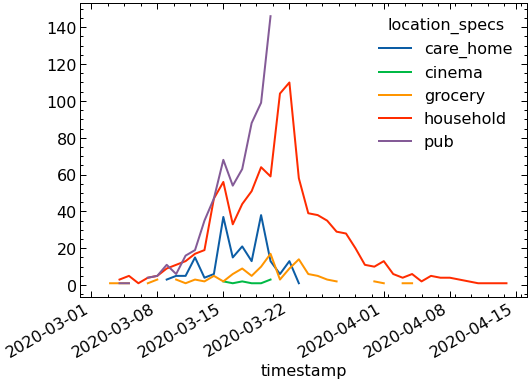

In [43]:
old_locations_df.unstack(level=0).plot()

## Prevalence by household size

In [44]:
household_people = people_df[
    people_df['residence_type'] == 'household'
]

In [45]:
household_sizes = household_people.groupby('residence_id').size()

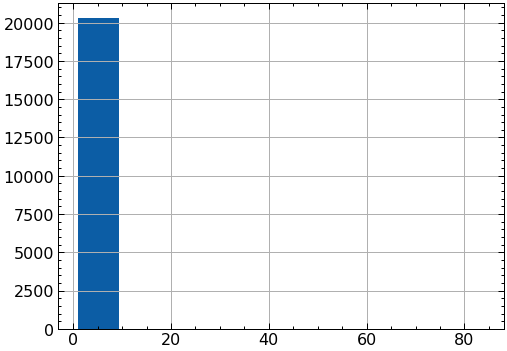

In [46]:
household_sizes.hist() # in units of households

In [47]:
household_people.loc[:,'household_size'] = household_sizes.loc[
    household_people['residence_id']
].copy(deep=True).values

/home/florpi/.local/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/florpi/.local/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


<AxesSubplot:>

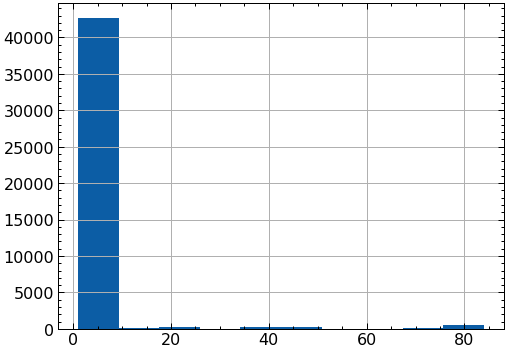

In [60]:
household_people['household_size'].hist() # in units of people

In [61]:
household_infections_df = infections_df.merge(
    household_people['household_size'], 
    left_index=True, right_index=True, how='inner'
)

(0.0, 8.0)

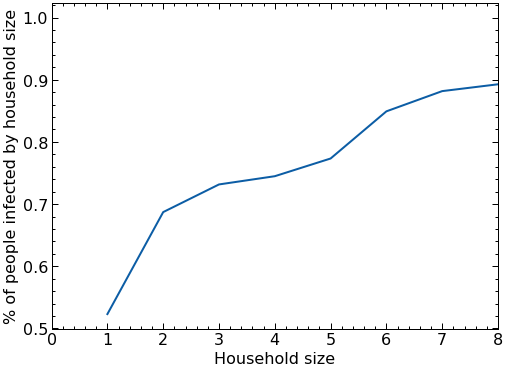

In [62]:
(household_infections_df.groupby(
    'household_size'
).size()/household_people.groupby('household_size').size()).plot()
plt.xlabel('Household size')
plt.ylabel('% of people infected by household size')
plt.xlim(0,8)

In [63]:
# How many households have everyone infected?

In [64]:
n_infected_by_household = infections_df[
    infections_df['residence_type'] == 'household'
].groupby('residence_id').size()

In [65]:
n_total_in_household = household_people[
    household_people['residence_id'].isin(
        n_infected_by_household.index
    )
].groupby('residence_id').size()

Text(0.5, 0, '% of the household infected')

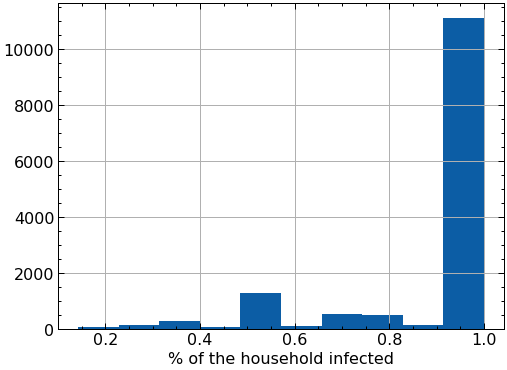

In [66]:
(n_infected_by_household/n_total_in_household).hist()
plt.xlabel('% of the household infected')

## Percentage of infected per care home

In [67]:
n_infected_by_carehome = infections_df[
    infections_df['residence_type'] == 'care_home'
].groupby(
    'residence_id'
).size()

In [68]:
n_total_in_carehome = people_df[
    (people_df['residence_type'] == 'care_home') 
    & (people_df['residence_id'].isin(n_infected_by_carehome.index))  
].groupby('residence_id').size()

Text(0.5, 0, '% of the care home infected')

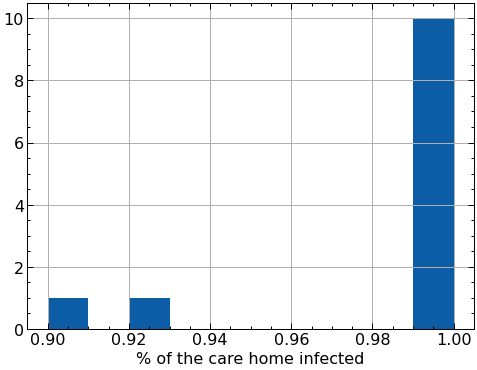

In [69]:
(n_infected_by_carehome/n_total_in_carehome).hist()
plt.xlabel('% of the care home infected')

In [70]:
# from all care homes, how many got at least one case?

In [71]:
n_total_care_homes = people_df[
    (people_df['residence_type'] == 'care_home') 
]['residence_id'].nunique()

In [72]:
n_total_care_homes

14

In [73]:
care_homes_with_infected = infections_df[
    (infections_df['residence_type'] == 'care_home') 
]['residence_id'].nunique()

In [74]:
care_homes_with_infected/n_total_care_homes

0.8571428571428571